# HCDE 410 Final Report #

## Abstract ##

This Jupter Notebook explores the relationship between COVID-19 cases and public sentiment via Twitter Tweets made during the pandemic. The purpose of this research is to demonstrate the predictive capabilies of machine learning in the public health sector. This report will also analyse the potential of using social media sentiment as a means of collecting user data. Through the utilization of a Random Forest Machine learning model, the Pearson correlation coefficient, and graphs we have concluded that there does not exist a correlation between the two variables in the studied datasets. However, the lack of evidence in this report does not indicate the absence of a relationship between the variables but rather highlights the need for further investigation with more complete data.

## Introduction ##

This research project explores the relationship between COVID-19 cases and public sentiment via Twitter Tweets made during the pandemic. The challenges of the COVID-19 were unique. Prolonged restrictions, supply shortages, and worrying hospitalizations contributed to an overall anxiety for the uncertainty of the future. American sentiment of the COVID-19 pandemic was diverse but often latent, a natural response to such a distruption to their everyday lives. When Stay-At-Home policies brought daily life to a standstill, news outlets and media became critical conveyors of COVID-19 statistics and trends. Social distancing measures isolated many, prompting Americans to turn to social media platforms like X (formerly Twitter) and Facebook to voice their frustrations and anxieties. 

As a student researcher, I have noticed there is an tendancy amoungst Americans to immediately voice their discontent with anything with directly on social media. This trait presents the opportunity to measure American sentiment by directly placing a finger on the pulse of American experiences. While current and effective methods exist to gather public opinion, reading American sentiment via social media may be a quicker and more honest method of data collection. We will explore the potential effectiveness of this method in this report and evaluate the value it may bring to the field of public health by analysing data on past pandemics. 

This report further continues the discussion of how, as user researchers, we can glean critical user artifacts to create better experiences. This method isn't just looking at hospital admittance records or polling responses for solutions to public health crises, it is an investigation into the expansive networks our societies communicate in. For example, an individual in a community may express negative sentiment on Twitter about a lack of adherence to public health policy, which may predict a potential spike in illness. Or a social media user could express positive sentiment for a well-organized vaccination drive in their neighborhood which may correspond with a decline of cases in the area. 

This report will investigate the supposed relationship between daily COVID-19 cases and the sentiment of daily Twitter Tweets. We will use two datasets from Kaggle, a database of Twitter tweets with sentiment labels from the 03-2020 and a database of daily reported COVID-19 cases in America. Futher descriptions of the datasets can be found in the README file of this report. We will be looking for correlation between the two datasets and building a machine learning model (ML) to explore how ML can be applied to public health.

## Research Questions ##

1. Can changes in public sentiment predict surges or declines in COVID-19 cases more effectively than traditional indicators?
2. How accurately can a machine learning model predict COVID-19 case trends using sentiment data as a feature?
3. How can sentiment analysis combined with epidemiological data contribute to more proactive public health responses?

## Related Work ##

Various academic researchers have also taken interest in the particular public sentiment during the COVID-19 pandemic. "Global Sentiments Surrounding the COVID-19 Pandemic on Twitter: Analysis of Twitter Trends" analysed sentiment trends via Twitter Tweets from January to April of 2020 [3]. Syntheized via WordClouds, they found public sentiment began with fear associated with xenophobia and shifted to anger related to stay-at-home policies. "Twitter conversations predict the daily confirmed COVID-19 cases" performed an investigation with similar goals to the ones in this report [1]. Using a time-series model, researchers found that latent social media variables offer additional prediction capabilites. This report differs because of our focus on American sentiment as opposed to Lamsal et al.'s Australian focus. 


## Creating the Dataset ##

Before creating the predictive machine learning model we need to prepare our data to be read. We will also create some graphs to better visualize the trends we will be evaluating. To begin we will import our libriaries. 
- "sklearn" is a kit from scikit-learn which will calculate regression algorithms for us.
- "matplotlib" will aid in plotting graphs
- "pandas"
- "numpy"
- "datetime"

**Acknowledgement:** ChatGPT 3.5 was used to in the ML creation portion of this report to aid in the construction of the model. While I performed research and wrote drafts of code independently, Generative AI was used to debug and suggest more efficient alternatives to my original work.

In [3]:
import requests
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

**Importing the datasets:** We will import our datasets from local folders using pd (pandas). 
- "Corona_NLP_train.csv" is our COVID-19 sentiment tweets CSV file.
- "us_counties_covid19_daily.csv" is the COVID-19 case count by day by US county.

In [19]:
tweet_file = pd.read_csv("Corona_NLP_train.csv", encoding='ISO-8859-1')
covid_file_3 = pd.read_csv("us_counties_covid19_daily.csv", encoding='ISO-8859-1')

**Cleaning the datasets:** In order to prepare the data for the ML algorithms we need to find a common column on each dataset. We also need to reformat the "date" column to be in the YYYY-MM-DD format to match the other dataset. Data was collected for the full year of 2020, but our second dataset only extends to April 2020 so we can cut down this dataset to clarity. We will also need to use ".groupby" to group the county data together for a total US case count.


In [49]:
covid_file_clean = covid_file_3[["date", "cases"]].copy()
covid_file_clean["date"] = pd.to_datetime(covid_file_clean["date"])
date_range = (covid_file_clean["date"] >= "2020-02-16") & (covid_file_clean["date"] <= "2020-12-14")
covid_file_filtered = covid_file_clean[date_range]
daily = covid_file_filtered.groupby("date")["cases"].mean().reset_index()
print(daily)

          date        cases
0   2020-02-16     1.363636
1   2020-02-17     2.083333
2   2020-02-18     2.083333
3   2020-02-19     2.083333
4   2020-02-20     2.076923
..         ...          ...
289 2020-12-01  4253.827065
290 2020-12-02  4312.923290
291 2020-12-03  4379.884781
292 2020-12-04  4451.879507
293 2020-12-05  4513.876771

[294 rows x 2 columns]


**Cleaning the datasets:** For the sentiment tweet dataset we need to extract the columns "Locations", "TweetAt", and "Sentiment". Then we need to reformat the column "TweetAt" to the YYYY-MM-DD format and rename that column to "date". Next we need to remap the sentiment labels in the file from "Extremely Negative", "Negative", "Neutral", "Positive", and "Extremely Positive" to "-2","-1","0","1", and "2", respectively. This will help us calculate an average sentiment score for each day. Finally we will find the average sentiment score for each day by grouping the data by the calendar date and then calculating the mean. 

In [50]:
tweet_file_clean = tweet_file[["Location", "TweetAt", "Sentiment"]].copy()
tweet_file_clean["TweetAt"] = pd.to_datetime(tweet_file_clean["TweetAt"], format="%d-%m-%Y").dt.date
tweet_file_clean = tweet_file_clean.rename(columns={"TweetAt": "date"})
sentiment_mapping = {"Extremely Negative": -2, "Negative": -1, "Neutral": 0, "Positive": 1, "Extremely Positive": 2}
tweet_file_clean["Sentiment"] = tweet_file_clean["Sentiment"].replace(sentiment_mapping)
daily_avg = tweet_file_clean.groupby("date")["Sentiment"].mean().reset_index()
print(daily_avg)

          date  Sentiment
0   2020-03-16   0.035061
1   2020-03-17  -0.023268
2   2020-03-18   0.006200
3   2020-03-19   0.012131
4   2020-03-20  -0.055394
5   2020-03-21   0.048624
6   2020-03-22   0.135289
7   2020-03-23   0.145490
8   2020-03-24   0.026351
9   2020-03-25   0.206781
10  2020-03-26   0.151135
11  2020-03-27  -0.011594
12  2020-03-28   0.956522
13  2020-03-29   0.368000
14  2020-03-30  -0.068966
15  2020-03-31   0.094937
16  2020-04-01   0.019048
17  2020-04-02   0.055556
18  2020-04-03   0.059259
19  2020-04-04   0.131682
20  2020-04-05   0.194518
21  2020-04-06   0.112514
22  2020-04-07   0.112317
23  2020-04-08   0.207868
24  2020-04-09   0.257648
25  2020-04-10   0.193035
26  2020-04-11   0.215622
27  2020-04-12   0.097136
28  2020-04-13   0.142857
29  2020-04-14   0.066901


**Merging the data:** Finally, we will merge the two cleaned datasets on the "date" column. Let's also print the merged dataset to take a look at what we will be working with.

In [51]:
daily["date"] = pd.to_datetime(daily["date"])
daily_avg["date"] = pd.to_datetime(daily_avg["date"])
merged_data = pd.merge(daily, daily_avg, how="inner", on="date")

print(merged_data)

         date       cases  Sentiment
0  2020-03-16    9.468487   0.035061
1  2020-03-17   10.816850  -0.023268
2  2020-03-18   13.046875   0.006200
3  2020-03-19   16.178851   0.012131
4  2020-03-20   19.663755  -0.055394
5  2020-03-21   23.721470   0.048624
6  2020-03-22   29.062390   0.135289
7  2020-03-23   35.485318   0.145490
8  2020-03-24   39.806642   0.026351
9  2020-03-25   44.759791   0.206781
10 2020-03-26   51.610374   0.151135
11 2020-03-27   57.874016  -0.011594
12 2020-03-28   65.834307   0.956522
13 2020-03-29   72.364652   0.368000
14 2020-03-30   79.128861  -0.068966
15 2020-03-31   87.534138   0.094937
16 2020-04-01   96.979289   0.019048
17 2020-04-02  106.800871   0.055556
18 2020-04-03  117.703012   0.059259
19 2020-04-04  130.002080   0.131682
20 2020-04-05  138.639196   0.194518
21 2020-04-06  148.334807   0.112514
22 2020-04-07  157.118017   0.112317
23 2020-04-08  167.591916   0.207868
24 2020-04-09  179.335258   0.257648
25 2020-04-10  189.952834   0.193035
2

**Looking at the data:** So it looks like that even though we had over a thousand data points for each dataset, when grouped by the date, data was only recorded for 30 days. This will not affect our results but may be a limitation we will address later.

## Graphing of COVID-19 Cases ##

**Why:** Before we begin working with the merged datasets let us take a look at the trends in each individual dataset. We will start by graphing the number of COVID-19 cases by day. We will use matplotlib.pyplot to help us create the graph. The x-axis will be the calendar date and the y-axis will be the number of COVID-19 cases per day.

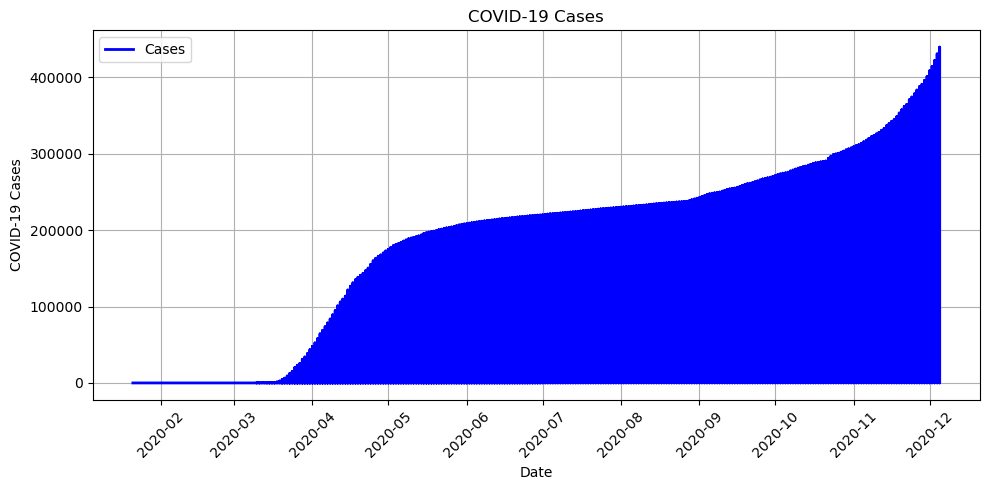

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(covid_file_clean["date"], covid_file_clean["cases"], label="Cases", color="blue", linewidth=2)

plt.title("COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('COVID-19-Cases.jpeg', format='jpeg', dpi=300)
plt.show()

**Analysis:** This graph is showing us that the number of COVID-19 cases peaked in 2022.

## Graph of COVID-19 Sentiment Twitter Tweets ##

**Why:** Let's now take a look at the trend of the COVID-19 sentiment Twitter tweets. We will use matplot.lib again for this. The x-axis will be the calendar date and the y-axis will be the sentiment score, a value between -2 and 2.

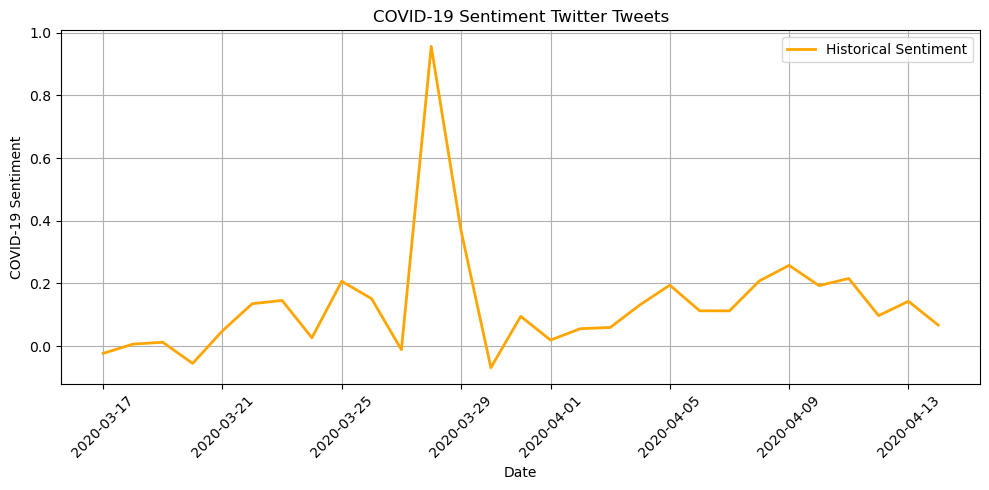

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(merged_data["date"], merged_data["Sentiment"], label="Historical Sentiment", color="orange", linewidth=2)

plt.title("COVID-19 Sentiment Twitter Tweets")
plt.xlabel("Date")
plt.ylabel("COVID-19 Sentiment")
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('COVID-19-Sentiment.jpeg', format='jpeg', dpi=300)
plt.show()


**Analysis:** This graph is showing us the fluctuations in sentiment following the initial outbreak of COVID-19 on 2020-03-13. There is also a noticeable peak in sentiment around 2020-03-27. When we examine the merged datasets we may be able to correlate the peak with a peak or dip in COVID-19 cases for that specific day.

**Comparison:** If we compare the two graphs from the same time frame it is difficult to deduce if there is a correlation between the two. There seems to be a generally low sentiment in tweets in the beginning of April 2020 and a spike in COVID-19 cases during that time as well. We will now create a machine learning model to further explore the realtionship and it's predictive capabilities.

## Creating a Machine Learning Model ##

**Why:** The goal of this project is to see if the correlation between COVID-19 tweets and sentiment tweets can predict future cases based on negative sentiment. We can train a predictive model using the merged dataset. We will need to explore the most user friendly way to present the data, and what independant and dependant variables we would like to define.

**Feature Engineering:** The goal of the following cell is to convert the date column into a format best suited for machine learning and create a learning lag. ".dropna" removes any rows that do not convert to the date format correctly to reduce chances of error. "cases_lag_1", and "sentiment_lag_1" create a lag in the two datasets. Lags are sometimes necessary to help models compare previous dates with future data. "days_since_start" column is created to create a distance or count of the number of days since the start of the dataset. This column is an important aspect of building the feature/independent variable dataframe later.

In [54]:
merged_data["date"] = pd.to_datetime(merged_data["date"], errors='coerce')
merged_data = merged_data.dropna(subset=["date"])
merged_data["cases_lag_1"] = merged_data["cases"].shift(1)
merged_data["sentiment_lag_1"] = merged_data["Sentiment"].shift(1)
merged_data = merged_data.dropna()
merged_data["days_since_start"] = (merged_data["date"] - merged_data["date"].min()).dt.days

print(merged_data)

         date       cases  Sentiment  cases_lag_1  sentiment_lag_1  \
1  2020-03-17   10.816850  -0.023268     9.468487         0.035061   
2  2020-03-18   13.046875   0.006200    10.816850        -0.023268   
3  2020-03-19   16.178851   0.012131    13.046875         0.006200   
4  2020-03-20   19.663755  -0.055394    16.178851         0.012131   
5  2020-03-21   23.721470   0.048624    19.663755        -0.055394   
6  2020-03-22   29.062390   0.135289    23.721470         0.048624   
7  2020-03-23   35.485318   0.145490    29.062390         0.135289   
8  2020-03-24   39.806642   0.026351    35.485318         0.145490   
9  2020-03-25   44.759791   0.206781    39.806642         0.026351   
10 2020-03-26   51.610374   0.151135    44.759791         0.206781   
11 2020-03-27   57.874016  -0.011594    51.610374         0.151135   
12 2020-03-28   65.834307   0.956522    57.874016        -0.011594   
13 2020-03-29   72.364652   0.368000    65.834307         0.956522   
14 2020-03-30   79.1

**Target Variables:** In the following cell we are building the feature and target variables for the model to train on. The X data is the feature or independant variable. The y_cases and y_sentiment are the dependant variables. The model will learn the relationship between the date and cases with sentiment.

In [55]:
X = merged_data[["cases_lag_1", "sentiment_lag_1", "days_since_start"]]
y_cases = merged_data["cases"]
y_sentiment = merged_data["Sentiment"]

**Splitting and Training the Model:** Now we are ready to train the model. We can start by splitting the dataset into a training and testing. "train_test_split" is a function from scikit, it will split the inputs/datset. For the cases test-train split we are inputting the feature/independent variables defined in the previously and the cases dataset from the merged_data field. "test_size = 0.2" indicates that 20% of the data will be in a dedicated testing set and the other 80% will be in a training set. "random_state = 42" is a fixed random seed. 

Our outputs will be "X_train" which is 80% of the independent data, "X_test" which is 20 of the independent data, "y_cases_train" which is 80% of the case data which will be used for training, and "y_cases_test" which is 20% of the cases data which will be used for testing. 

Similarly, we will utilize the same function for the sentiment tweets. Our output will be "y_sentiment_train" which is 80% of the sentiment data and will be used in training the model, and "y_sentiment_test" which is the remaining 20% of the data, to be used for testing.

In [56]:
X_train, X_test, y_cases_train, y_cases_test = train_test_split(X, y_cases, test_size=0.2, random_state=42)
_, _, y_sentiment_train, y_sentiment_test = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)


**Scaling:** As reconmended by VIDEO we will be using scikit's preprossessing function to scale our datasets. Scaling standardizes large datapoints to make sure the model is not skewed by these points. It calculates the mean and standard deviation of each point an converts the mean to 0 and the standard deviation to 1.This does not alter the data drastically, we can print the independent variable datasets to compare.

In [57]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Chosing an Algorithm ##

**Random Forest Regressors:** We will use a Random Forest Regressor to form the algorithm of our model. Random Forest Regressor models forms multiple decision trees and combines each tree's prediction into an average as an output. The trees are trained on random sets of data. The "split" or branches of the decision trees minimize error and overfitting yet gives the model the opportunity for broader predictions.

**Linear Regression Models:** For this project I chose not to use a linear regression model because we are assuming a lack of knowledge of correlation between the two datasets. Linear Regression models work best with realtionships that are generally linear. Given that COVID-19 data usually fluctuates, this model would not be ideal for our purposes.

**Support Vector Machines and Other Classification Models:** I chose not to use a classification model for this project but there exist future applications of them in this project. Classification models output catagorical predictions. However, given that predicting a specific classification of sentiment is not the goal of my project. I have chosen not to use a classificaiton model. As discussed further in the Application and Limitations sections, if I chose to create my own Tweet sentiment database, I could use a classification model like Kernel Support Vector Machines and other non-linear methods to sentiment tag my own collection of COVID-19 tweets. 

**Training the Model:** Now we will use the two datasets to train the model independently using a Random Forest Regressor algorithm from scikit. 

In [58]:
cases_model = RandomForestRegressor(n_estimators=100, random_state=42)
cases_model.fit(X_train_scaled, y_cases_train)

sentiment_model = RandomForestRegressor(n_estimators=100, random_state=42)
sentiment_model.fit(X_train_scaled, y_sentiment_train)


RandomForestRegressor(random_state=42)

**Creating an Interface:** Now, with our model trained and ready for use, we can create a user interface for our model. We will use the function "input" to create a prompt. Based on we have found that the best way for users to interact with the model is by having the user enter a date and expect an output of COVID-19 cases and related sentiment score. While the score and case number might not mean a lot to a user by itself, this Jupter Notebook preps the user with the necessary information to make this data contextually understandable. Understanding this model is reliant on a baseline knowledge of the trends and relationship between the two variables we have explored. Thus, this model and interface are not prepared to be used independently from the notebook. 

**Implementing the Model:** First, the user will be prompted to enter the date they are interested in making a prediction on. The following error statement is broken down and labeled below:
1. We are converting the user input into pandas readable format and dropping any rows that have an invalid date format. This is to prevent any errors, especially if this model were to be scaled up. Additionally we are 
2. Finds the last know case and sentiment score for each dependant variable by pulling the value from the last column.
3. Creates a dataframe for the independent/feature variables. Also makes sure that the columns are in the same order that the model was trained on.
4. Scales the features again using ".transform" to stabilize the independent variables again.
5. Uses the case_model and sentiment_model regressor models with the scaled dataframe of features to make a prediction of the sentiment and cases based on the user input.
6. Creates a plot showing the the model's prediction against the previous trends. We can use this graph to determine the accuracy of the model during the first month of the pandemic.

In [66]:
def predict_covid_sentiment(user_date, merged_data, scaler, cases_model, sentiment_model):
    try:
        #1
        user_date_obj = pd.to_datetime(user_date)
        merged_data["date"] = pd.to_datetime(merged_data["date"], errors='coerce')
        merged_data = merged_data.dropna(subset=["date"])
        days_since_start = (user_date_obj - merged_data["date"].min()).days

        #2
        last_known_cases = merged_data["cases"].iloc[-1]
        last_known_sentiment = merged_data["Sentiment"].iloc[-1]

        #3 
        future_features = pd.DataFrame({
            "days_since_start": [days_since_start],
            "cases_lag_1": [last_known_cases],
            "sentiment_lag_1": [last_known_sentiment],
        })
        future_features = future_features[["cases_lag_1", "sentiment_lag_1", "days_since_start"]]

        #4
        future_features_scaled = scaler.transform(future_features)

        #5
        future_cases = cases_model.predict(future_features_scaled)
        future_sentiment = sentiment_model.predict(future_features_scaled)
        print(f"Predicted Cases for {user_date}: {future_cases[0]:.2f}")
        print(f"Predicted Sentiment for {user_date}: {future_sentiment[0]:.2f}")

        #6
        plt.figure(figsize=(10, 5))
        plt.plot(merged_data["date"], merged_data["cases"], label="Historical Cases", color="blue", linewidth=2)
        plt.plot(merged_data["date"], merged_data["Sentiment"], label="Historical Sentiment", color="orange", linewidth=2)
        plt.scatter([user_date_obj], [future_cases[0]], color="cyan", label="Predicted Cases", zorder=5)
        plt.scatter([user_date_obj], [future_sentiment[0]], color="red", label="Predicted Sentiment", zorder=5)

        plt.title("COVID-19 Cases and Sentiment Predictions")
        plt.xlabel("Date")
        plt.ylabel("Counts / Sentiment")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('COVID-19-Model.jpeg', format='jpeg', dpi=300)
        plt.show()

    except ValueError as e:
        print(f"Invalid date format. Please enter the date in YYYY-MM-DD format. Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


**Try it:** Run the following cell below and input a date from 2020-03-17 to 2020-04-14. 

Enter a date (YYYY-MM-DD) for prediction:  2020-04-05


Predicted Cases for 2020-04-05: 165.09
Predicted Sentiment for 2020-04-05: 0.12


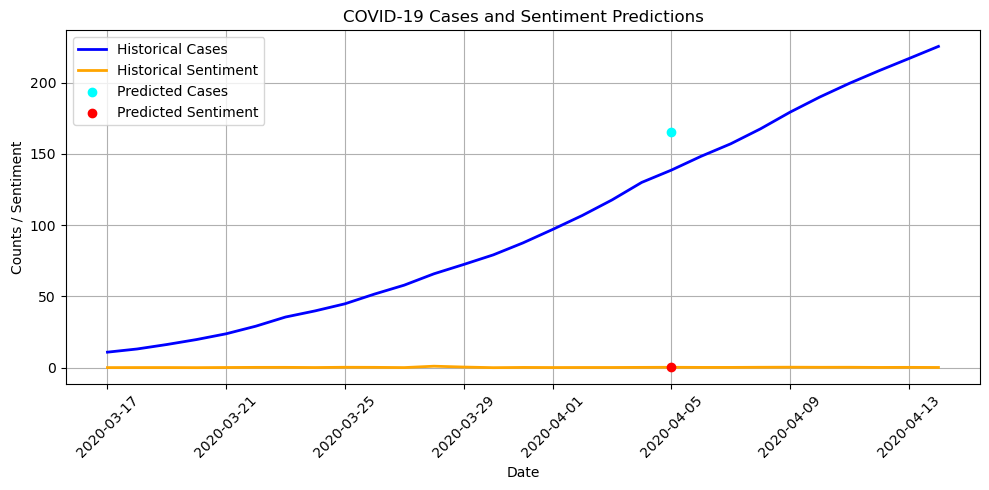

In [68]:
user_date = input("Enter a date (YYYY-MM-DD) for prediction: ")
predict_covid_sentiment(user_date, merged_data, scaler, cases_model, sentiment_model)

**Recommendations:** When testing the model, first try some dates from the first month of the pandemic. For example:
- 2020-03-19
- 2020-03-29
- 2020-04-05

Dates before the pandemic are valid but not not accurate. Dates far in the future are also valid but not accurate. Dates not within the first month of the pandemic will not show a real-world trendline for accuracy. This could be improved with a larger dataset.

**Performance:** Based on the graph, we can see that the model prediction is not too far off from the actual trend of COVID-19 cases for that day. Although near-perfect accuracy is expected, especially since the exact data for this specific date is provided to the model, so there is room for improvement. We can compare its ability to predict future cases by looking at acutal COVID-19 data that is separate from our dataset. Try running the model again in the cell below with the date "2023-12-01" and compare the cases with the date on this graph from Worldometers.com https://www.worldometers.info/coronavirus/country/us/#graph-cases-daily


Try inputing 2023-12-01 for a prediction:  2023-12-01


Predicted Cases for 2023-12-01: 206.96
Predicted Sentiment for 2023-12-01: 0.09


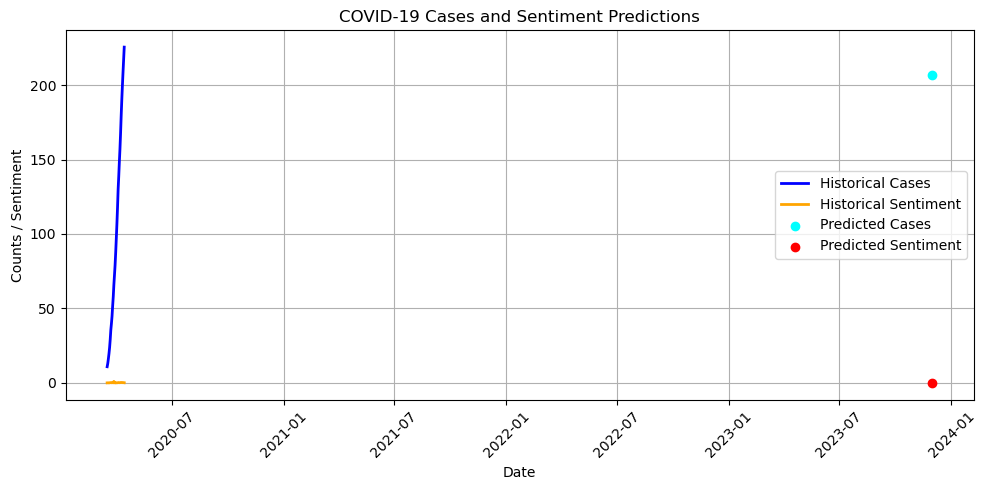

In [61]:
user_date = input("Try inputing 2023-12-01 for a prediction: ")
predict_covid_sentiment(user_date, merged_data, scaler, cases_model, sentiment_model)

**Yikes:** Evidently, this model is not great at predicting long term COVID-19 cases. The graph is not able to adapt to future trends due to insufficent data. We will address some reasons why in the limitations section and how it could be improved. However, as we saw in the earlier graph, this model does preform generally well at predicting cases in the months it is given data on. To improve its forcasting ability we would need significantly more data. Considering that our data collection stops before cases peaked in 2021, the model does not understand enough of the trend to predict accurately.

**Correlation:** We intially began this report to find a correlation between sentiment and COVID-19 cases. While we can study the trendlines of our graphs, we can also quickly run the following code to find the correlation coefficient between the two using ".corr".

In [62]:
merged_data_clean = merged_data.dropna(subset=["Sentiment", "cases"])

correlation = merged_data_clean["Sentiment"].corr(merged_data_clean["cases"])

print(f"Correlation between sentiment and COVID-19 cases: {correlation:.2f}")

if np.abs(correlation) > 0.7:
    print("Strong correlation")
elif np.abs(correlation) > 0.4:
    print("Moderate correlation")
else:
    print("Weak or no correlation")

Correlation between sentiment and COVID-19 cases: 0.14
Weak or no correlation


## Discussion ##

**Relationship:** There appears to be no relationship between COVID-19 cases and the sentiment of Twitter tweets from the pandemic according to the correlation coefficient. However, this does not mean that there is no relationship between the two. As we will discuss in the limitations section, our dataset is small, a larger dataset may yield a higher correlation coefficient.    

**Applications:** Unique applications exist for this model. In this project we only explored inputting the date to predict COVID-19 cases and sentiment. However, if we were to configure the model to take sentiment as an input, we could predict COVID-19 cases based on just the daily Twitter sentiment alone. These kinds of predictions could aid in public health efforts by being able to forcast epidemics just based social media activity.   Given that our correlation coefficient is negative we would likely not be able to use this current model to predict COVID-19 cases.

Online and in-person behavior are closely linked and as the digital landscape of this generation continues to grow we may need to begin to make efforts to understand the relationship soon. Twitter was chosen as the social media platform for this report because of its design that encourages sharing of organic thoughts. This is particularly relevant in the COVID-19 pandemic scenario, where the rapid spread of information (and misinformation) has had tangible impacts on public behavior and policy decisions. The growing dominance of social media platforms like Twitter means that the digital world is increasingly influencing real-world events, and understanding this relationship will be critical for a variety of fields, including public health, 

**Black-Box Dismantling:** The primary aim of this project was to build a working machine learning model but in a transparent way that encourages public consumption and learning. Through this project we went through each step of the building process in hopes of contributing to the dismantling of the "black-box" narrative surrounding AI. As an undergrad not directly majoring in computer science, the process of building a machine learning model was entirely foreign to me. But this project showed me that this learning is not confined to practitioners in the CS field. I hope that the transparent nature of this notebook aids in demystifying machine learning and builds trust between humans and technology.

## Limitations ##

**Dataset Limitations:** Despite the accomplishment of creating my first machine learning model, this project could have been improved in several ways. Firstly, the dataset could have been chosen more carefully. When selecting a dataset I aimed for one with many rows of data with a goal of providing enough data to train my model to be as accurate as possible. The "Corona_NLP_train.csv" dataset looked seemed like a perfect option given that it had over a thousand rows of data on daily COVID-19 Twitter tweets. However, after cleaning and grouping the data by date I found that tweets were only collected for the first 30 days in this dataset, meaning my average sentiment score calculations would only yield 30 datapoints, which is less than ideal for training an ML model. Despite this being a performance limitation, it did give me leniency when creating the model. Mistakes were easier to catch and troubleshooting dataset issues was much easier. While researching, I did find a dataset used by researchers to accomplish similar goals to my model. Lamsal et al. collected years worth of COVID-19 tweets and tagged them with sentiment ratings [4]. However, each file was enormous and far to large to download onto my computer. If I were to recreate this project with an aim of higher accuracy, I would utilize this dataset. 

**Dataset Noise:** Additonally, the sentiment scores collected from the dataset I used could be subject to bias. According to the description on Kaggle "manual tagging" was performed. Regardless of what the manual tagging process entailed, this dataset is still subject to bias from the orginal authors. Alternatively, I could create another model to sentiment rate my own COVID-19 tweets. I briefly looked into this process and found the process of automating based on keywords quite facinating. I have also observed that the method of "averaging" the sentiment score by day effectively "dampens" extremely negative or positive views. We see in our merged_data dataset that average daily sentiment scores did not often surpass -1 or +1, when the fully range was -2 to +2. While I have not found a better way to represent the views of more extreme tweets I recognize that this is a current limition of this model. 

**Mathematical Model:** In this project we used a Random Forest Regression model to preform our predictions. While this model aiding us in achieving our goal to a certain extent, there will always be room for improvements. I was mainly bound by my lack of coding skills when selecting a model from my research. I was tempted to implement a model such as Support Vector Machine as a challenge but feared that sunk cost fallacy would threaten my ability to hand in the project on time and completed. In the future, I look forward to expanding my mathematical knowledge in hopes of becoming competent enough to build a better perfoming model.  

## Conclusion ##

In this report, we have explore the relationship between COVID-19 cases and the sentiment of Twitter tweets from the pandemic. We have sucessfully produced a small machine learning model that is able to accurately predict the number of COVID-19 cases as well as the average sentiment for that day. Despite the model being unable to perform accurate future predictions, I believe this could be fixed with the inclusion of more training data. However, based on the dataset used, there appears to be no correlation between COVID-19 and Twitter sentiment. Future work can be run on this model by importing and cleaning datasets to match the current variables.

## References ##


[1]R. Lamsal, A. Harwood, and M. R. Read, “Twitter conversations predict the daily confirmed COVID-19 cases,” Applied Soft Computing, vol. 129, p. 109603, Nov. 2022, doi: [https://doi.org/10.1016/j.asoc.2022.109603].

[2]“12. Choosing the right estimator,” scikit-learn, 2024. [https://scikit-learn.org/stable/machine_learning_map.html]

[3]M. O. Lwin et al., “Global sentiments surrounding the COVID-19 pandemic on Twitter (Preprint),” JMIR Public Health and Surveillance, vol. 6, no. 2, Apr. 2020, doi: [https://doi.org/10.2196/19447].

[4]R. Lamsal, “Coronavirus (COVID-19) Tweets Dataset,” ieee-dataport.org, Mar. 2020, Available: [https://ieee-dataport.org/open-access/coronavirus-covid-19-tweets-dataset]

[5]“Build your first machine learning model in Python,” [www.youtube.com. https://www.youtube.com/watch?v=29ZQ3TDGgRQ]

[6]Seldon, “How to Build a Machine Learning Model,” Seldon, Sep. 11, 2021. [https://www.seldon.io/how-to-build-a-machine-learning-model]